# V1 Model 

V1 model 

# Introduction to Apache Cerebrum 

## Motivation

- Large public databases provide extensive and detailed maps of the brain (e.g. Brain Atlas) . 
- Using such atlases for the construction of computational models remains a challenge. 
- Diverse databases are required for construction of detailed models.
   - Spatial transcriptomics data allows for regional and layer-wise distributions of the different cell types. 
   - Synaptic physiology databases provide connection probabilities between the sets of neuron classes. 
- Data from diverse sources incorporated to construct detailed models 

## Cerebrum Goals 

- Flexible and extendable software that allows queries over different databases and brain atlases.
- Applies transformations such as maps and filters on the resultant data.
- Incorporate results within the computational models described using SONATA format


## Workflow Structure

Workflow to construct in Cerebrum follows the following steps: 

1. Extract data from experimental and brain atlas datasets via querying the  relevant databases. 
2. Map acquired data to regions of interest. 
3. Fill-in any missing details via an optional user-defined custom modifications. 
4. Realize the final network of neurons in SONATA format from the model recipe.

<div>
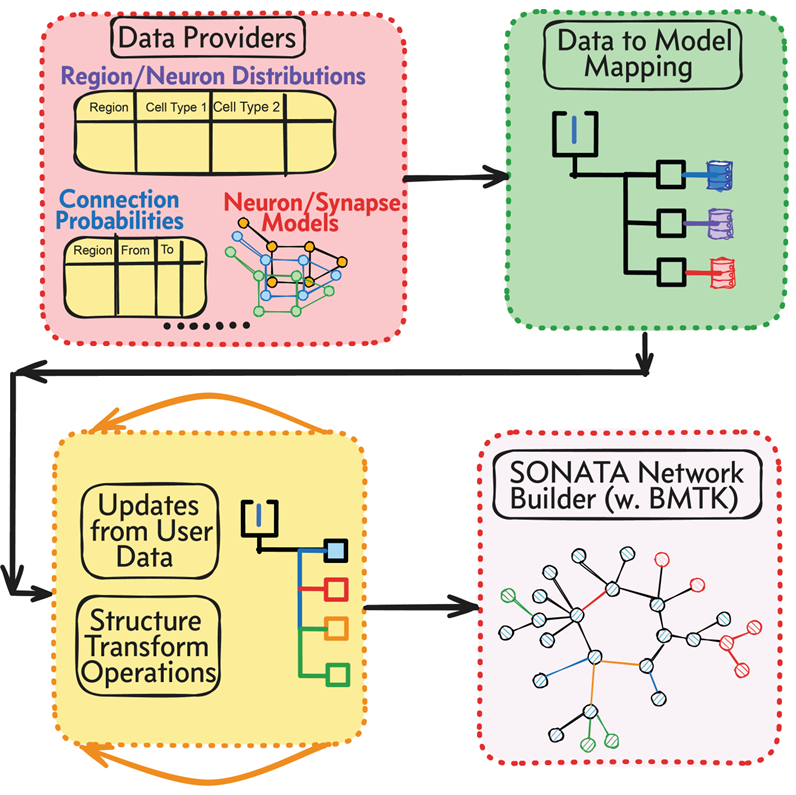
</div>

In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import logging
from typing import NamedTuple
import pydantic
import nest
#
from pathlib import Path
#
from nest.lib.hl_api_sonata import SonataNetwork
from nest.lib.hl_api_nodes import Create as NestCreate
from nest.lib.hl_api_connections import Connect as NestConnect
from nest.lib.hl_api_types import NodeCollection
#
import mousev1.model as v1model
import mousev1.operations as v1ops
from airavata_cerebrum.recipe import RecipeSetup, ModelRecipe
from airavata_cerebrum.model.structure import Network
from airavata_cerebrum.view.tree import DataSourceRecipeView, Data2ModelRecipeView, NetworkStructureView



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: May  5 2025 12:50:25

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



/storage/ideas/is-schockalingam6-0/phe/spack/opt/spack/linux-cascadelake/miniforge3-24.3.0-0-xgjqahntab2nzxf2nfab5k5ixrky2z2n/envs/cerebrum/lib/python3.10/site-packages/neuroanalysis/util/jit.py:25: UserWarning:Could not import numba; falling back to slower implementation.


# Model Recipe
Model Recipe defines key components for constructing a Model Network with Cerebrum. 

- **Data Providers:** Links to source database and query parameters
- **Filter and Transformers:** Filter via selection criteria on the queried data.
- **Data2Model Mappers:** Mapper methods that map data to model components.
- **User Modifications:** User Inputs that modify the data-derived model


<div>
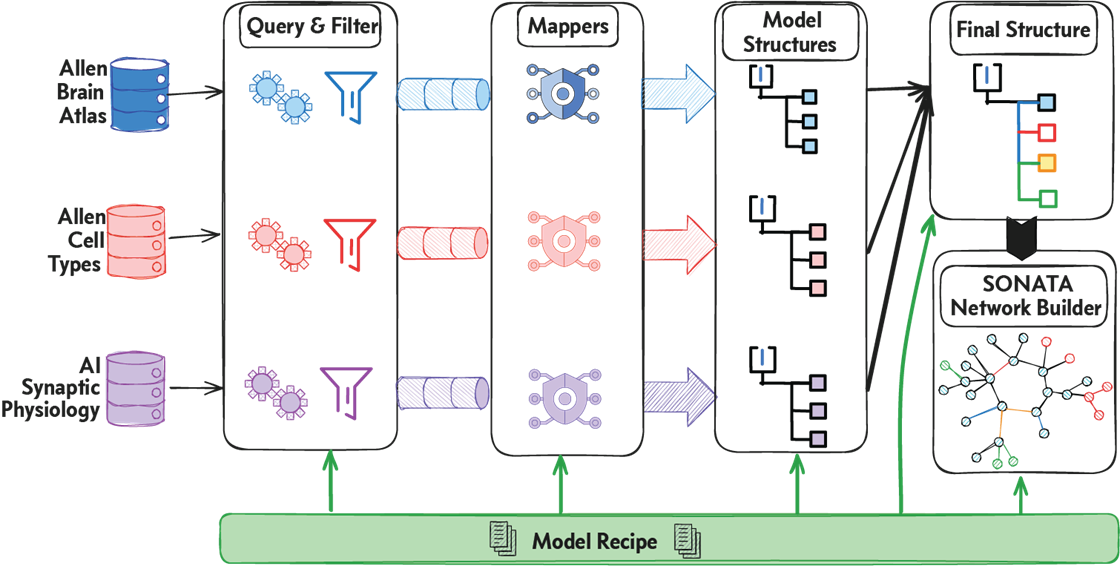
</div>

## V1 Model Recipe

Model recipe is defined by a collection of files under the recipe directory. Here, we use the directory `model_recipes/v1`.

Recipe json files contains three sections: 
1. **source_data section :** describes how the source databases are connected and different operations such as filters are applied to the data available from the specific database.
2. **data2model_map section :** data2model_map section describes how the source data is mapped to the different parts of the model.
3. **custom mod section :** describes the user modifications applied after a model skeleton is applied to the data.

The template file `recipe_template.json` used for rendering the repice as a tree structure in the notebook.

In [3]:
class RcpSettings(pydantic.BaseModel):
    name: str = "v1"
    ncells: int = 30000
    enable_timing: bool = True
    logging_level: int = logging.DEBUG
    root_logging_level: int = logging.DEBUG
    base_dir: Path = Path("./model_builds/v1030")
    recipe_dir: Path = Path("./model_recipes/v1")
    recipe_output_dir: Path | None = Path("./model_data/v1")
    levels: list[str] = ["L1",  "L23", "L4", "L5", "L6"]
    recipe_levels: dict[str, str | Path] = {
        "L1"  : "recipe_dm_l1.json",
        "L23" : "recipe_dm_l23.json",
        "L4"  : "recipe_dm_l4.json",
        "L5"  : "recipe_dm_l5.json",
        "L6"  : "recipe_dm_l6.json",
    }
    custom_mod_main : Path = Path("./model_recipes/v1/custom_mod.json")
    custom_mod_levels: dict[str, str | Path] = {
        "L1"  : Path("./model_recipes/v1/custom_mod_l1.json"),
        "L23" : Path("./model_recipes/v1/custom_mod_l23.json"),
        "L4"  : Path("./model_recipes/v1/custom_mod_l4.json"),
        "L5"  : Path("./model_recipes/v1/custom_mod_l5.json"),
        "L6"  : Path("./model_recipes/v1/custom_mod_l6.json"),
    }
    custom_mod_exts : list[str | Path] = [
        Path("./model_recipes/v1/custom_mod_ext.json"),
        Path("./model_recipes/v1/custom_mod_ext_lgn.json"),
        Path("./model_recipes/v1/custom_mod_ext_bkg.json"),
    ]
    ctdb_models_dir: Path = Path("./model_components/point_neuron_models/")
    nest_models_dir: Path = Path("./model_components/cell_models/")
    save_flag: bool = True
    
    @property
    def output_dir(self) -> Path:
        return Path(
            self.recipe_output_dir if self.recipe_output_dir else self.recipe_dir
        )

    @property
    def recipe_files(self) -> dict[str, list[str | Path]] :
        """The recipe_files property."""
        full_recipe = ["recipe.json", "recipe_data.json"] + [
            self.recipe_levels[lx] for lx in self.levels
        ]
        return {
            "recipe": full_recipe,
            "templates": [ "recipe_template.json" ]
        }

    @property
    def custom_mod(self) -> list[str | Path] :
        return [
            self.custom_mod_main,
        ] + [
            self.custom_mod_levels[lx] for lx in self.levels
        ] + self.custom_mod_exts

    def recipe_setup(self):
        return RecipeSetup(
            name=self.name,
            base_dir=self.base_dir,
            recipe_files=self.recipe_files,
            recipe_dir=self.recipe_dir,
            recipe_output_dir=self.output_dir,
            create_model_dir=True,
        )


rcp_set = RcpSettings()
md_recipe_setup = rcp_set.recipe_setup()
custom_mod_struct = Network.from_file_list(rcp_set.custom_mod) 

# Source Data

Cerebrum defines multiple data provider modules. It includes
  - Methods for defining the querying from the database and filter the data based on specific criteria. 
  - Utilities to visualize the data provider configurations in easy-to-understand explorer view inside Jupyter notebook with the relevant parameters displayed in the side panel.

Construction of Mouse V1 is shown below with three different data providers: 
  - Allen Cell Types database,
  - Allen Brain Cell Atlas,
  - AI Synaptic Physiology Database, and
  - Gouwens et. al. (2019) neuron classification based on electrophysiolocial data.

In [4]:
import IPython.display

IPython.display.JSON(md_recipe_setup.get_section('source_data'))

<IPython.core.display.JSON object>

## Visualize Source Data

Using the templates we can view the links to the source data and the model with Jupter notebook widgets. 

<div>
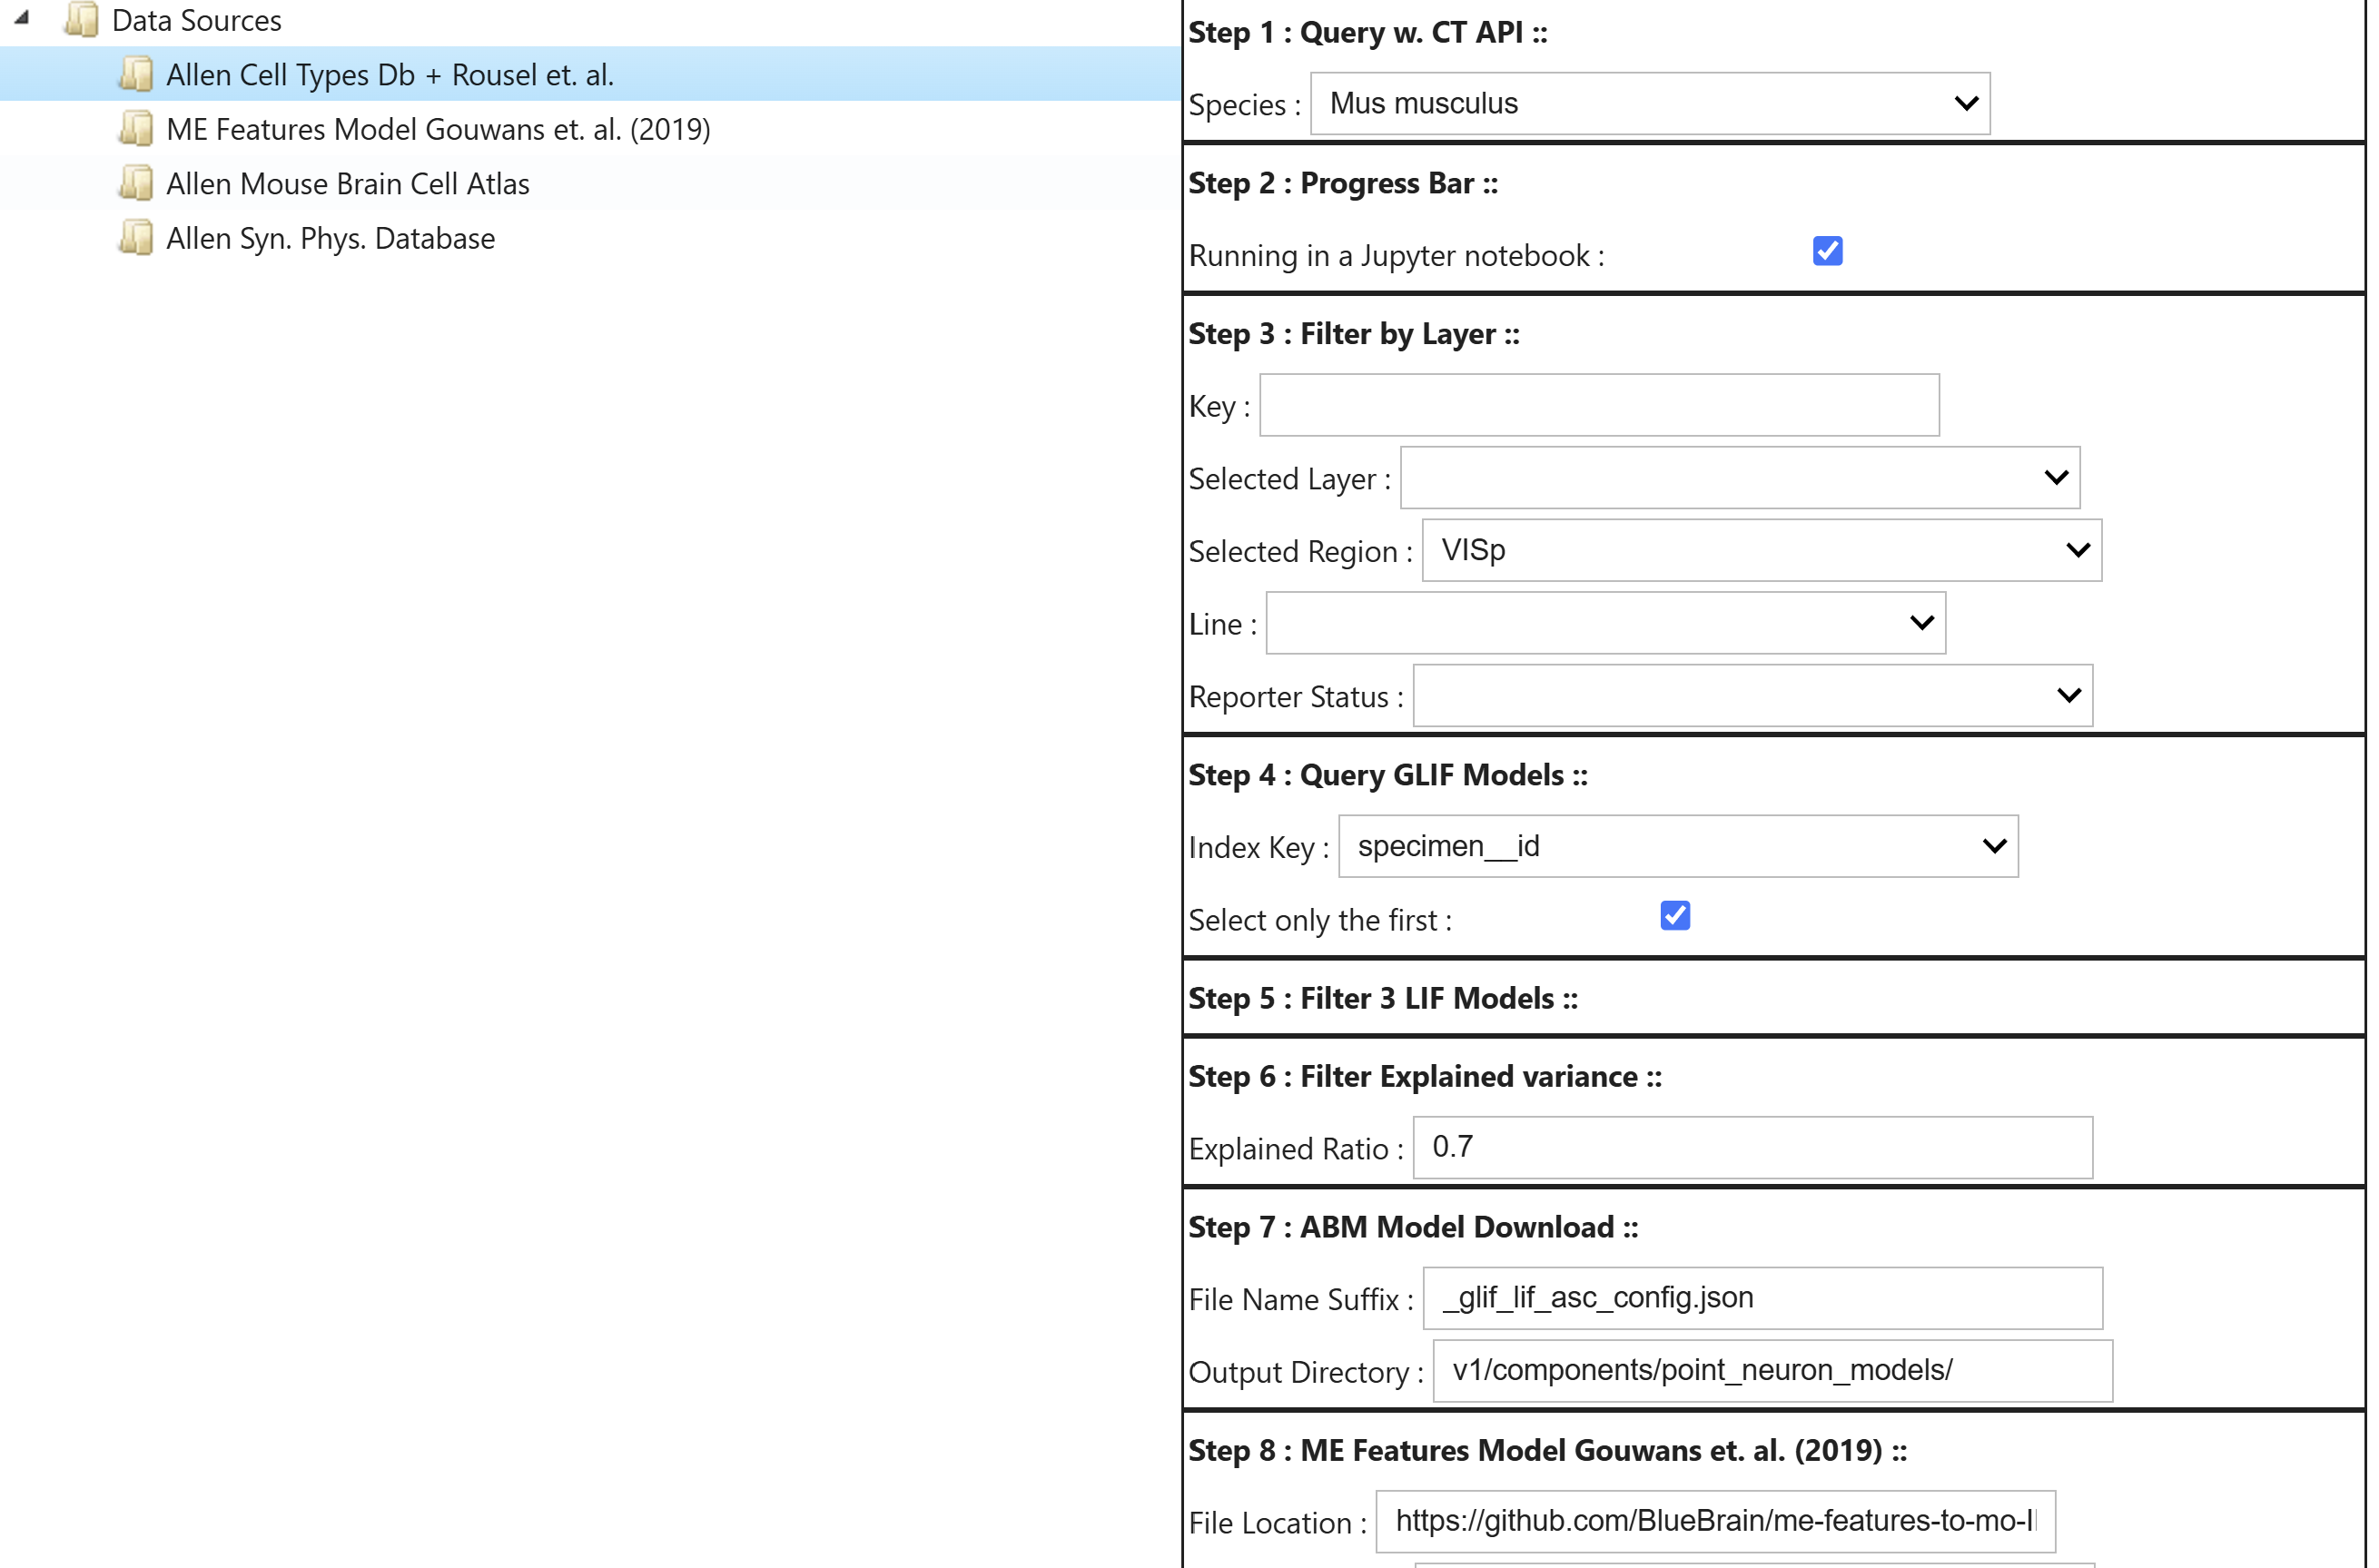
</div>

**NOT shown in the static notebook**

In [5]:
sd_tree = DataSourceRecipeView(md_recipe_setup, left_width="55%")
sd_tree.build()
sd_tree.layout

TwoByTwoLayout(children=(Tree(data={'id': '-source_data', 'text': 'Data Sources', 'state': {'selected': True, …

# Data2Model Mapping

Definitions for data2model_map includes two parts:

1. *Locations:*
    - Locations are defined hiearchially with each section defining the data links.
    - For V1, data from Cell types database and the MERFISH atlas map to neuron models and the distribution of neuron types, respectively
    - For V1, we map eight different neuron types to the specific models and the region fractions. 
3. *Connections:*
    - Connections are defined as section for each pair to neuron sets, with each section defining the data links.
    - AI synaptic physiology data is mapped to the connection probabilities between the pairs of neuron classes.
    - For V1, we map each of the different neuron pairs to the AI Syn. Phys. Data outputs     

In [6]:
import IPython.display

IPython.display.JSON(md_recipe_setup.get_section('data2model_map'))

<IPython.core.display.JSON object>

### Visualize Data2Model Mapping
Using the templates we can view the links to the neuron pairs and the source data with Jupter notebook widgets.

<div>
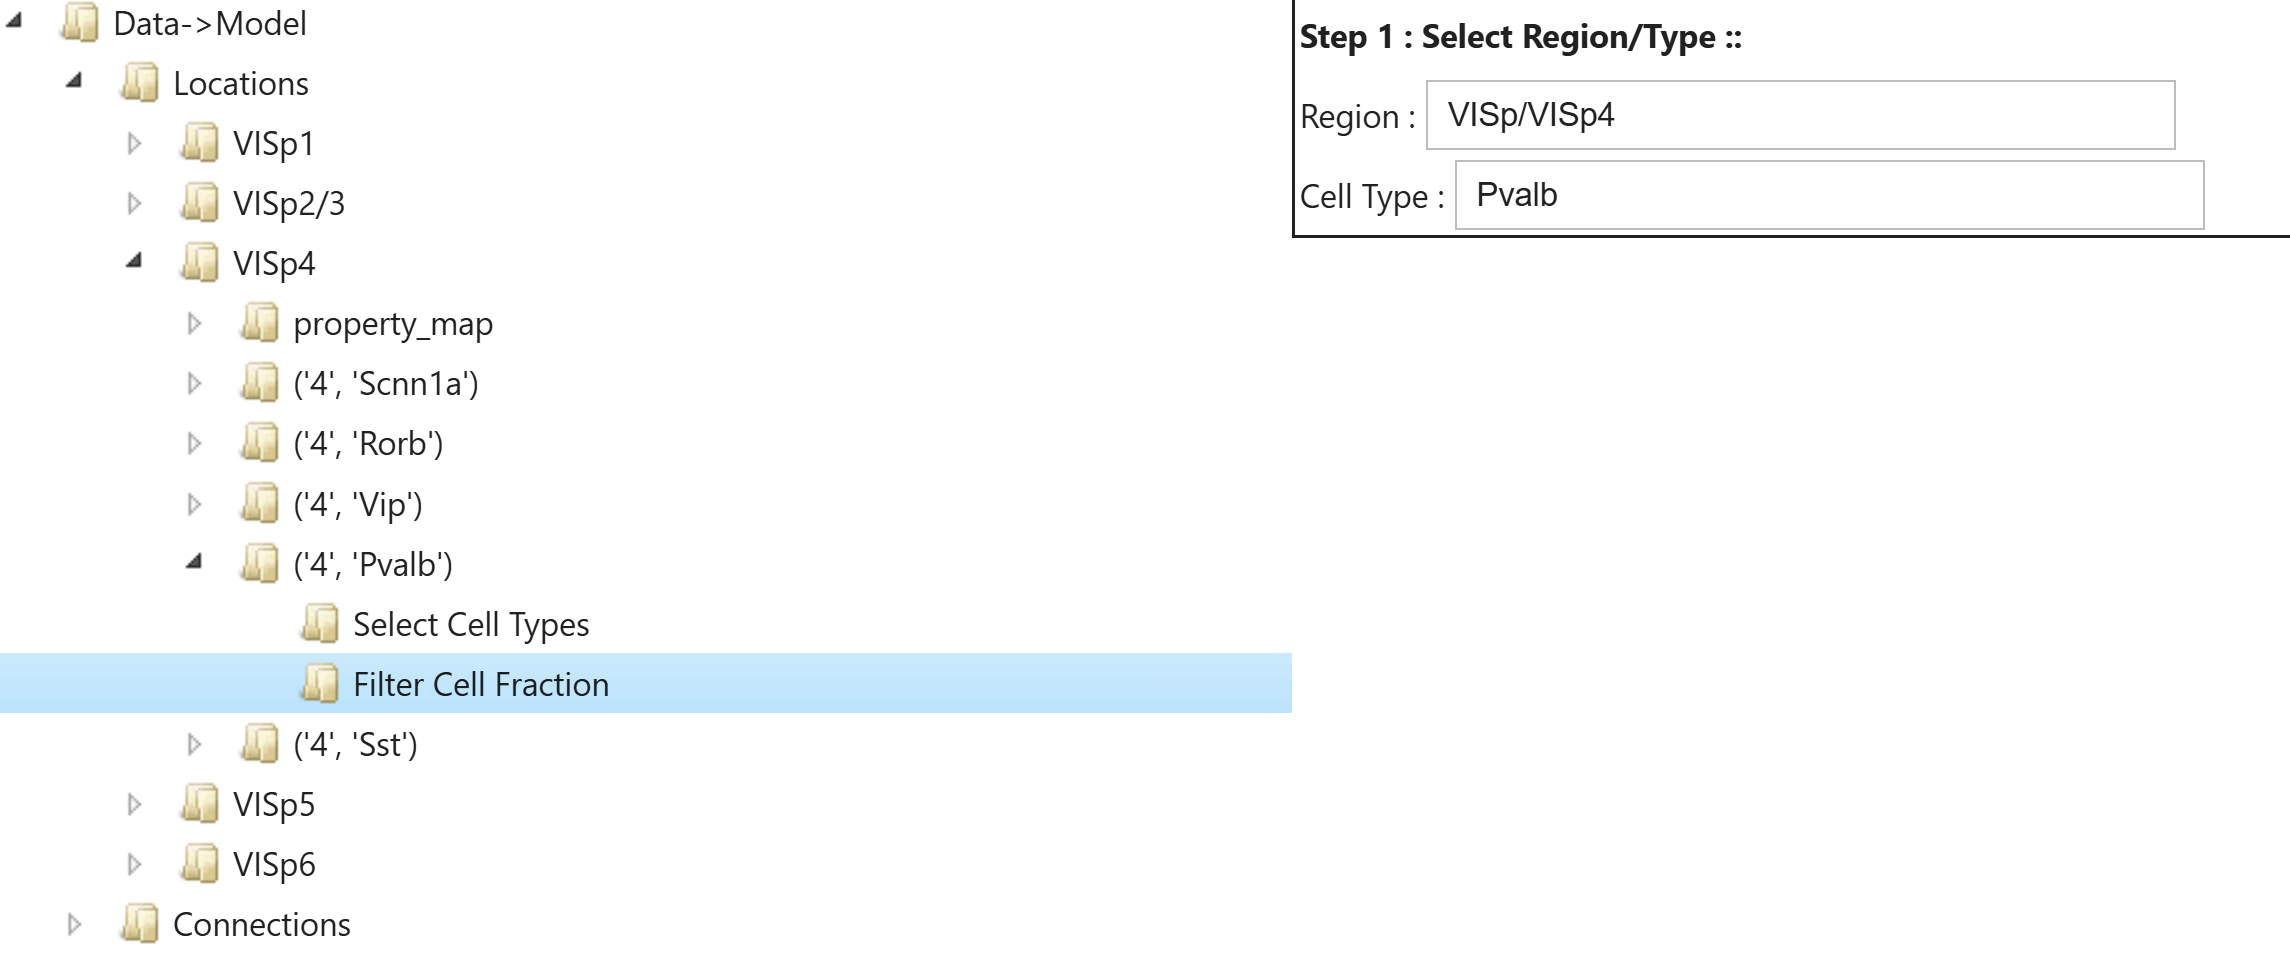
</div>

**NOT shown in the static notebook**

In [7]:
dm_tree = Data2ModelRecipeView(md_recipe_setup, width="55%")
dm_tree.build()
dm_tree.layout

TwoByTwoLayout(children=(Tree(data={'id': '-data2model_map', 'text': 'Data->Model', 'state': {'selected': True…

# Custom Modifications

Custom modifications to the data-driven model skeleton:
- Users can provide details required for network construction that are either not available in the linked databases or over-ride specific information.
- Utilities to visualize these modifications in Jupyter Notebook.

For the Mouse V1, custom modifications include 
1. Dimensions of each region in the model.
2. Connection Parameters not available with the AI Syn. Phys. database.
3. Details of the networks that are external to V1 : LGN and the background networks. 


In [8]:
import IPython.display

IPython.display.JSON(custom_mod_struct.model_dump())

<IPython.core.display.JSON object>

### Visualize Custom Mod structure

Using the templates we can view the user custom modifications with Jupter notebook widgets. 

**Due to Size Restrictions, this doesn't work in ipython for now**

In [ ]:
cmod_view = cbm_tree.NetworkStructureView(custom_mod_struct, left_width="55%")
cmod_view.build()
cmod_view.layout

# Mappers for SONATA Network
To realize model recipe to SONATA Network, define three python classes

1. *Region Mapper* : Maps the location details to a region in the network.
2. *Neuron Mapper* : Map the neuron details within in a location to a neuron class within the region.
3. *Connection Mapper*: Map the connection data to a connection object in the network of neurons.

In addition a *Network Builder* class is also defined that translates the model description to SONATA network. 

In [11]:
from mousev1.model import (
    V1BMTKNetworkBuilder,
    V1ConnectionMapper,
    V1NeuronMapper,
    V1RegionMapper
)

model_recipe = ModelRecipe(
    recipe_setup=md_recipe_setup,
    region_mapper=V1RegionMapper,
    neuron_mapper=V1NeuronMapper,
    connection_mapper=V1ConnectionMapper,
    network_builder=V1BMTKNetworkBuilder,
    mod_structure=custom_mod_struct,
    save_flag=rcp_set.save_flag,
)


logging.basicConfig(level=logging.INFO)

# Data Acquistition

Data acquisition consists of the following two steps:

## Run Data Download Workflow

After the model description is defined and updated with custom user modifications, the download workflow proceeds as follows:
1. Query and download the data from different databases of interest.
2. Apply the filters and transormations.
3. Save downloaded data to a local database.

## Run Download Post Operations

After data is dowloaded, the data obtained from different databases need to processed separately:

1.  In case of the Allen Cell Type database, the download step can be restricted only to obtain the metadata related to cell types. After the meta data is downloaded, we need to acquire the models of interest (3 LIF Models). We use the GLIF API from allensdk to download these 3LIF model with a explained variance threshold. Further filter is applied based on the classification by *Gouwens et. al. (2019)*.
2.  For data from Allen Brain Cell Atlas, we filter the data specific to only the VISp region.
3.  For AI Syn Phys. data, we select only the neuron pairs of our interest.

We accomplish the above two steps by running `recipe.acquire_source_data()` function.

In [9]:
db_source_data = model_recipe.acquire_source_data()

  0%|          | 0/2333 [00:00<?, ?it/s]

/storage/hive/project/cse-aluru/schockalingam6/spack/opt/spack/linux-rhel9-cascadelake/gcc-12.3.0/miniforge3-24.3.0-0-aqhmckaascr5r262m24t2yk3fjx52dqs/envs/cerebrum/lib/python3.10/site-packages/aisynphys/connectivity.py:323: RuntimeWarning:Mean of empty slice.
/storage/hive/project/cse-aluru/schockalingam6/spack/opt/spack/linux-rhel9-cascadelake/gcc-12.3.0/miniforge3-24.3.0-0-aqhmckaascr5r262m24t2yk3fjx52dqs/envs/cerebrum/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning:invalid value encountered in double_scalars
/storage/hive/project/cse-aluru/schockalingam6/spack/opt/spack/linux-rhel9-cascadelake/gcc-12.3.0/miniforge3-24.3.0-0-aqhmckaascr5r262m24t2yk3fjx52dqs/envs/cerebrum/lib/python3.10/site-packages/aisynphys/connectivity.py:329: RuntimeWarning:invalid value encountered in long_scalars
/storage/hive/project/cse-aluru/schockalingam6/spack/opt/spack/linux-rhel9-cascadelake/gcc-12.3.0/miniforge3-24.3.0-0-aqhmckaascr5r262m24t2yk3fjx52dqs/envs/cerebrum/lib/python3

# Explore downloaded data

Output data are stored in the description directory in json format `(db_connect_output.json)`, which can be examine with json library. Here are examples of Region and Neuron fractions of the Allen Brain Atlas, and connectivity matrix downloaded from AI Syn. Phys. dataset. 

Output data is also stored as duckdb database `db_connect_output.db`, which can be used for more detailed queries.

In [12]:
import json
#
with open("./model_data/v1/db_connect_output.json") as dbf:
    db_out_data = json.load(dbf)


In [13]:
import airavata_cerebrum.dataset.abc_mouse as abcm
abcm.DFBuilder.build(db_out_data['airavata_cerebrum.dataset.abc_mouse'])

shape: (6, 17)
┌────────┬───────┬─────────┬─────────────┬───┬─────────────┬─────────────┬────────────┬────────────┐
│ Region ┆ Layer ┆ nregion ┆ inhibitory  ┆ … ┆ ET fraction ┆ CT fraction ┆ NP         ┆ IT         │
│ ---    ┆ ---   ┆ ---     ┆ fraction    ┆   ┆ ---         ┆ ---         ┆ fraction   ┆ fraction   │
│ str    ┆ str   ┆ i64     ┆ ---         ┆   ┆ f64         ┆ f64         ┆ ---        ┆ ---        │
│        ┆       ┆         ┆ f64         ┆   ┆             ┆             ┆ f64        ┆ f64        │
╞════════╪═══════╪═════════╪═════════════╪═══╪═════════════╪═════════════╪════════════╪════════════╡
│ VISp   ┆ 1     ┆ 61884   ┆ 0.405155    ┆ … ┆ 0.0         ┆ 0.0         ┆ 0.0        ┆ 0.989601   │
│ VISp   ┆ 2/3   ┆ 61884   ┆ 0.078755    ┆ … ┆ 0.0         ┆ 0.0         ┆ 0.0        ┆ 1.0        │
│ VISp   ┆ 4     ┆ 61884   ┆ 0.111916    ┆ … ┆ 0.029334    ┆ 0.000212    ┆ 0.007413   ┆ 0.962618   │
│ VISp   ┆ 5     ┆ 61884   ┆ 0.165428    ┆ … ┆ 0.323039    ┆ 0.043953    ┆ 0.104137   ┆ 0.521258   │
│ VISp   ┆ 6a    ┆ 61884   ┆ 0.062779    ┆ … ┆ 0.000611    ┆ 0.75932     ┆ 0.005378   ┆ 0.215988   │
│ VISp   ┆ 6b    ┆ 61884   ┆ 0.05291     ┆ … ┆ 0.0         ┆ 0.725559    ┆ 0.0        ┆ 0.046788   │
└────────┴───────┴─────────┴─────────────┴───┴─────────────┴─────────────┴────────────┴────────────┘

In [14]:
import airavata_cerebrum.dataset.ai_synphys as aisp
aisp.DFBuilder.build(db_out_data['airavata_cerebrum.dataset.ai_synphys'])

shape: (289, 3)
┌─────────────┬──────────────┬──────────────┐
│ pre_synapse ┆ post_synapse ┆ connect_prob │
│ ---         ┆ ---          ┆ ---          │
│ str         ┆ str          ┆ f64          │
╞═════════════╪══════════════╪══════════════╡
│ L23-Pyr     ┆ L23-Pyr      ┆ 0.072655     │
│ L23-Pyr     ┆ L23-Pvalb    ┆ 0.538204     │
│ L23-Pyr     ┆ L23-Sst      ┆ 0.386245     │
│ L23-Pyr     ┆ L23-Vip      ┆ 0.207773     │
│ L23-Pyr     ┆ L4-Pyr       ┆ 0.056222     │
│ …           ┆ …            ┆ …            │
│ L6-Vip      ┆ L5-Vip       ┆ 0.039576     │
│ L6-Vip      ┆ L6-Pyr       ┆ 0.0          │
│ L6-Vip      ┆ L6-Pvalb     ┆ 0.064641     │
│ L6-Vip      ┆ L6-Sst       ┆ 0.079542     │
│ L6-Vip      ┆ L6-Vip       ┆ 0.012808     │
└─────────────┴──────────────┴──────────────┘

# Map Source data to Model

In this step, the data downloaded is mapped to the locations and the connection pairs as mentioned in "Data2Model Map" section above.


In [15]:
logging.basicConfig(level=logging.INFO)
#
msrc = model_recipe.map_source_data()

INFO:airavata_cerebrum.workflow:Processing db connection for neuron [property_map]
INFO:airavata_cerebrum.workflow:Start op workflow for db [airavata_cerebrum.dataset.abc_mouse]
INFO:airavata_cerebrum.workflow:Running XFormer : [Select Region]
INFO:airavata_cerebrum.workflow:Complete XForm : [Select Region]
INFO:airavata_cerebrum.workflow:Complete op workflow for db [airavata_cerebrum.dataset.abc_mouse]
INFO:airavata_cerebrum.workflow:Completed db connection for neuron [property_map]
INFO:airavata_cerebrum.workflow:Processing db connection for neuron [('1', 'Htr3a')]
INFO:airavata_cerebrum.workflow:Start op workflow for db [airavata_cerebrum.dataset.abm_celltypes]
INFO:airavata_cerebrum.workflow:Running XFormer : [Select Line]
INFO:airavata_cerebrum.operations.dict_filter:IterAttrFilter Args : (key:ct, filters:[('structure__layer', <built-in function eq>, '1'), ('line_name', <built-in function contains>, 'Htr3a'), ('cell_reporter_status', <built-in function eq>, 'positive')])
INFO:aira

# Apply Custom Modification
As mentioned in the "Custom Modifications" section above, user updates for the model are loaded from `./v1/description/custom_mod.json`.

For V1, the user modification include dimension, additional connection properties, and properties of external netowrks

In [16]:
IPython.display.JSON(custom_mod_struct.model_dump())

<IPython.core.display.JSON object>

In [17]:
msrc = model_recipe.build_net_struct()
msrc = model_recipe.apply_mod(30000)

# Build Network with BMTK :: Initialize 

In this step this configuation is used to initialize the nodes and edges based on the data downloaded and custom modifications applied.


In [18]:
bmtk_net_builder = V1BMTKNetworkBuilder(model_recipe.network_struct)
bmtk_net = bmtk_net_builder.build()

INFO:mousev1.model:('1', 'Htr3a') 482654108 482654108 696 4051
INFO:mousev1.model:('1', 'Htr3a') 475585413 475585413 696 4051
INFO:mousev1.model:('1', 'Htr3a') 482649712 482649712 696 4051
INFO:mousev1.model:('2/3', 'Cux2') 513593674 513593674 963 4075
INFO:mousev1.model:('2/3', 'Cux2') 513510227 513510227 963 4075
INFO:mousev1.model:('2/3', 'Cux2') 486262299 486262299 963 4075
INFO:mousev1.model:('2/3', 'Cux2') 490376252 490376252 963 4075
INFO:mousev1.model:('2/3', 'Cux2') 486753754 486753754 963 4075
INFO:mousev1.model:('2/3', 'Cux2') 489751692 489751692 963 4075
INFO:mousev1.model:('2/3', 'Cux2') 513531471 513531471 963 4075
INFO:mousev1.model:('2/3', 'Cux2') 505512874 505512874 963 4075
INFO:mousev1.model:('2/3', 'Cux2') 517319635 517319635 963 4075
INFO:mousev1.model:('2/3', 'Cux2') 484509440 484509440 963 4075
INFO:mousev1.model:('2/3', 'Vip') 524689239 524689239 26 2720
INFO:mousev1.model:('2/3', 'Vip') 524693113 524693113 26 2720
INFO:mousev1.model:('2/3', 'Vip') 501736631 501

# Save SONATA

Save SONATA with BMTK

**Skipping Save SONTA as it takes a siginificant amount of time. For a model of 30K cells, it takes about an hour. (files are make available in "./model_builds/v1030" folder)** 

In [ ]:
bmtk_net_builder.save(str(md_recipe_setup.network_dir))

# Update/Change of the Model

1. Directly Update the json to add update queries/parameters
2. Load parts of json by splitting into differnet files
3. Custom query classes by subclassing DBQuery.
4. Custom mapper functions by subclassing OpXformer.
5. Custom SONATA network builder classes.

In [ ]:
def data_mapped_model(levels: tuple[str,...]=("L1", "L23", "L4")):
    mdrcp = model_recipe(RcpSettings(levels=list(levels)))
    mdrcp.map_source_data()
    mdrcp.build_net_struct()
    mdrcp.apply_mod()
    mdrcp.build_network()

data_mapped_model(("L4"))

# Post Processing
## Convert downloaded models to NEST confirmed models

The format of the glif properties json files present  in the cell types database

**Skipping Save SONTA as it takes a siginificant amount of time. For a model of 30K cells, it takes about an hour. (files are make available in "./model_builds/v1030" folder)** 

In [ ]:
# Converting to 
import mousev1.operations as mousev1ops
import nest
import matplotlib.pyplot as plt

mousev1ops.convert_ctdb_models_to_nest(
    "./v1/components/point_neuron_models/",
    "./v1/components/cell_models/"
)


# Run the SONATA Network in NEST

1. Convert downloaded models to NEST confirmed models
2. Load SONATA network in NEST
3. Run Simulation

In [20]:

with open("./model_builds/v1030/config.json") as ifx:
    cfg_dict = json.load(ifx)

IPython.display.JSON(cfg_dict)

<IPython.core.display.JSON object>

In [21]:
import v1_bmtk_simulate 
import pandas as pd
import h5py
import seaborn as sns

In [22]:
def spikes_dataf(spikes_h5):
    with h5py.File(spikes_h5) as sfx:
        sfspikes = sfx['/spikes/v1']
        snodes = sfspikes['node_ids']
        stimes = sfspikes['timestamps']
        return pd.DataFrame(data={
            'node_id':snodes[:snodes.len()],
            'timestamp':stimes[:stimes.len()]
        })
    return None


def nodes_dataf(nodes_h5):
    with h5py.File(nodes_h5) as vifx:
        ntypes = vifx['/nodes/v1/node_type_id']
        nyes = vifx['/nodes/v1/0/y']
        nids = vifx['/nodes/v1/node_id']
        return pd.DataFrame(data={
            'node_id':nids[:nids.len()],
            'y':nyes[:nyes.len()],
            'node_type_id': ntypes[:ntypes.len()]
        })

def lgn_dataf(lgn_h5):
    with h5py.File(lgn_h5) as lfx:
        ltimes = lfx['spikes/timestamps']
        lgids = lfx['spikes/gids']
        return pd.DataFrame(data={
            'gid':lgids[:lgids.len()],
            'time':ltimes[:ltimes.len()]
        })


def node_types_dataf(nodes_types_csv):
    ntypesdf = pd.read_csv(nodes_types_csv, sep=' ')
    ntypesdf['layer'] = ntypesdf['pop_name'].str.replace('(', '', regex=False).str.replace(')', '', regex=False).str.split(',').str[0]
    ntypesdf['cell_type'] = ntypesdf['pop_name'].str.replace('(', '', regex=False).str.replace(')', '', regex=False).str.split(',').str[-1]
    return ntypesdf[['node_type_id', 'ei', 'location','pop_name', 'layer', 'cell_type']]
    
    

In [23]:
v1_bmtk_simulate.main("./model_builds/v1030/config.json", 16)

2025-07-09 11:45:12,171 [INFO] Created log file


INFO:NestIOUtils:Created log file


2025-07-09 11:45:13,562 [INFO] Batch processing nodes for v1/0.


INFO:NestIOUtils:Batch processing nodes for v1/0.


2025-07-09 11:45:13,799 [INFO] Batch processing nodes for lgn/0.


INFO:NestIOUtils:Batch processing nodes for lgn/0.


2025-07-09 11:45:13,851 [INFO] Batch processing nodes for bkg/0.


INFO:NestIOUtils:Batch processing nodes for bkg/0.


2025-07-09 11:45:15,309 [INFO] Setting up output directory


INFO:NestIOUtils:Setting up output directory


2025-07-09 11:45:15,316 [INFO] Building cells.


INFO:NestIOUtils:Building cells.


2025-07-09 11:45:16,506 [INFO] Building recurrent connections


INFO:NestIOUtils:Building recurrent connections


2025-07-09 11:45:25,954 [INFO] Network created.


INFO:NestIOUtils:Network created.


2025-07-09 11:45:25,957 [INFO] Build virtual cell stimulations for LGN_spikes


INFO:NestIOUtils:Build virtual cell stimulations for LGN_spikes


2025-07-09 11:45:58,794 [INFO] Build virtual cell stimulations for BKG_spikes


INFO:NestIOUtils:Build virtual cell stimulations for BKG_spikes


2025-07-09 11:45:59,937 [INFO] Starting Simulation


INFO:NestIOUtils:Starting Simulation


2025-07-09 11:46:08,746 [INFO] Simulation finished, finalizing results.


INFO:NestIOUtils:Simulation finished, finalizing results.


2025-07-09 11:46:11,228 [INFO] Done.


INFO:NestIOUtils:Done.


In [24]:
lgndf = lgn_dataf("./model_lgn/full3_GScorrected_PScorrected_3.0sec_SF0.04_TF2.0_ori270.0_c100.0_gs0.5_spikes.trial_0.h5")
lgndf

gid         time
0           0   677.465750
1           0   706.951454
2           0   716.273214
3           0   759.103046
4           0   809.736841
...       ...          ...
337641  17399  2711.425680
337642  17399  2723.924696
337643  17399  2733.776178
337644  17399  2799.512497
337645  17399  2811.065294

[337646 rows x 2 columns]

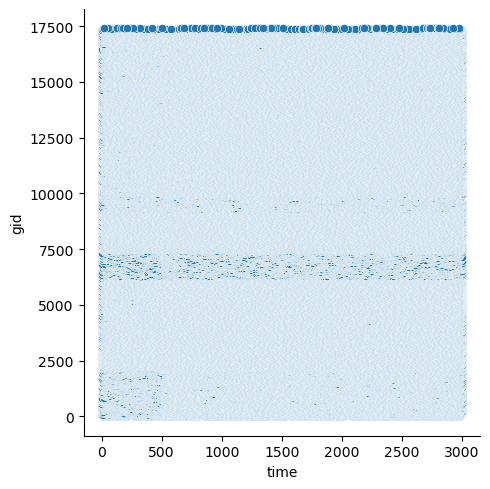

In [25]:
sns.relplot(data=lgndf, x="time", y="gid")

In [26]:
spikes_df = spikes_dataf("./model_builds/v1030/v1/output/spikes.h5")
nodes_df = nodes_dataf("./model_builds/v1030/v1/network/v1_nodes.h5")
node_types_df = node_types_dataf("./model_builds/v1030/v1/network/v1_node_types.csv")

node_spikes_df = pd.merge(pd.merge(spikes_df, nodes_df), node_types_df)
node_spikes_df

node_id  timestamp           y  node_type_id ei location  \
0           244    2754.00 -137.927379     482654108  i    VISp1   
1           153    2283.50 -161.764235     482654108  i    VISp1   
2           153    1333.75 -161.764235     482654108  i    VISp1   
3           684    1643.75  -78.955271     482654108  i    VISp1   
4           684    1581.75  -78.955271     482654108  i    VISp1   
...         ...        ...         ...           ... ..      ...   
311480    23080    2745.75 -623.279117     591627904  i    VISp5   
311481    27240    1844.50 -715.062022     502382506  i    VISp6   
311482    20846    2746.00 -645.830280     486110216  e    VISp5   
311483    20846    2286.75 -645.830280     486110216  e    VISp5   
311484    24798    1720.50 -760.684647     471819401  e    VISp6   

              pop_name layer cell_type  
0       ('1', 'Htr3a')   '1'   'Htr3a'  
1       ('1', 'Htr3a')   '1'   'Htr3a'  
2       ('1', 'Htr3a')   '1'   'Htr3a'  
3       ('1', 'Htr3a')   '1'   'Htr3a'  
4       ('1', 'Htr3a')   '1'   'Htr3a'  
...                ...   ...       ...  
311480    ('5', 'Vip')   '5'     'Vip'  
311481    ('6', 'Sst')   '6'     'Sst'  
311482     ('5', 'IT')   '5'      'IT'  
311483     ('5', 'IT')   '5'      'IT'  
311484  ('6', 'Ntsr1')   '6'   'Ntsr1'  

[311485 rows x 9 columns]

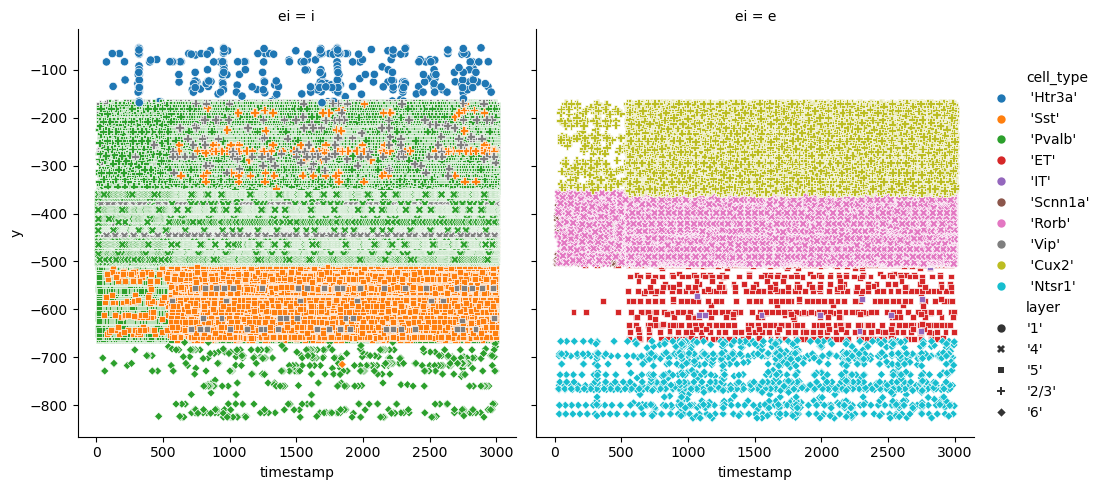

In [27]:
sns.relplot(data=node_spikes_df, x="timestamp", y="y", col="ei", hue="cell_type", style="layer")

In [1]:
import matplotlib.pyplot as plt
import mousev1.plotting_utils as mpu

pointnet_config = 'model_builds/v1030/full_path_config.json'
net = 'full'
sortby='tuning_angle'
radius = 400.0


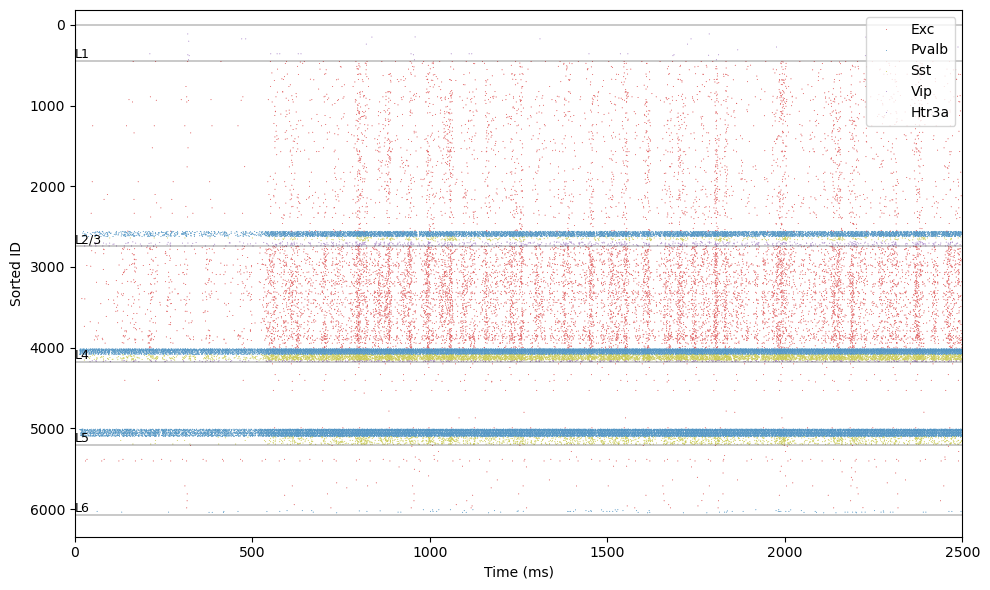

In [2]:
plt.figure(figsize=(10, 6))


ax = mpu.plot_raster(pointnet_config, sortby=sortby, **mpu.settings[net])
ax.set_xlim([0, 2500])
plt.tight_layout()

In [3]:
spikes_df, hue_order, color_dict, layer_divisions = mpu.make_figure_elements(pointnet_config, radius, sortby)
# calculate firing rates
rates = spikes_df[spikes_df['timestamps']>500.0].groupby(['Sorted ID'])['timestamps'].count()/2.5
rates = rates.reset_index(name = 'Mean Rate')
rates_df = spikes_df[['population', 'Sorted ID', 'Cell Type', 'Tuning Angle', 'layer']].drop_duplicates('Sorted ID')
rates_df = rates_df.merge(rates, how='left', left_on='Sorted ID', right_on = 'Sorted ID')

<Axes: xlabel='layer', ylabel='Mean Rate'>

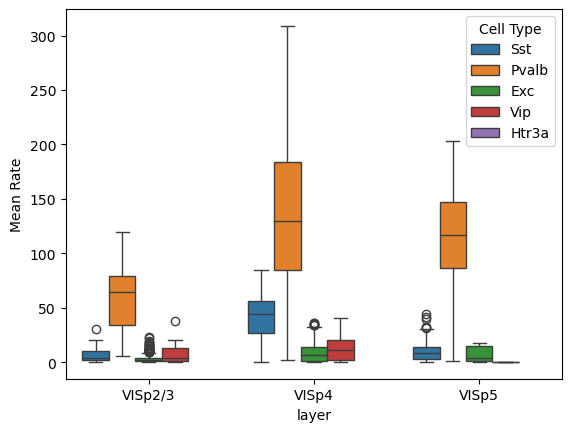

In [4]:
import seaborn as sns
sns.boxplot(rates_df, x='layer', y='Mean Rate', hue='Cell Type', order=['VISp2/3', 'VISp4', 'VISp5'])

<Axes: xlabel='layer', ylabel='Mean Rate'>

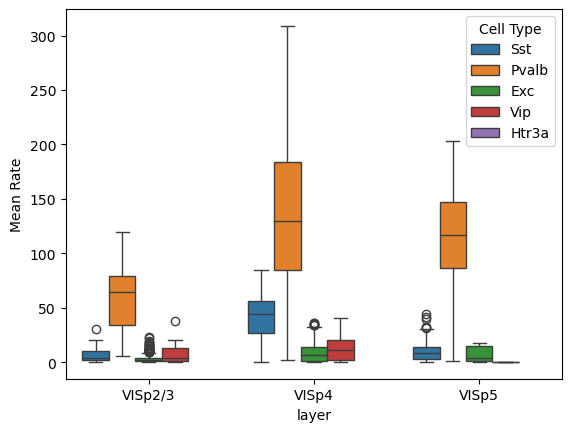

In [5]:
import seaborn as sns
sns.boxplot(rates_df, x='layer', y='Mean Rate', hue='Cell Type', order=['VISp2/3', 'VISp4', 'VISp5'])

In [6]:
angles_list = [0.0, 45.0, 90.0, 135.0, 180.0, 225.0, 270.0, 315.0, 360.0]
rates_df['Tuning Angle'] = rates_df['Tuning Angle'].round()
rates_df = rates_df[rates_df['Tuning Angle'].isin(angles_list)]


<Axes: xlabel='Tuning Angle', ylabel='Mean Rate'>

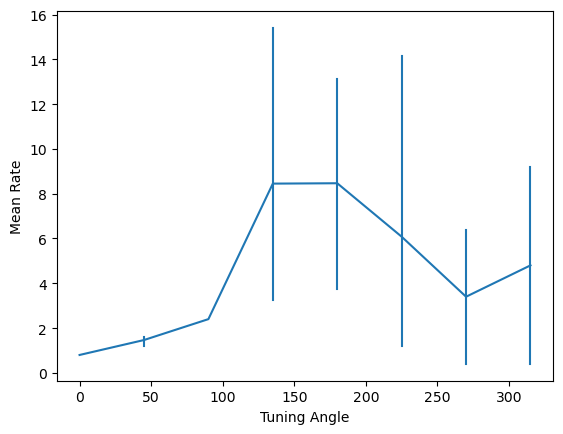

In [7]:
sns.lineplot(rates_df[rates_df['Cell Type']=='Exc'], x='Tuning Angle', y='Mean Rate', err_style='bars')

<Axes: xlabel='Tuning Angle', ylabel='Mean Rate'>

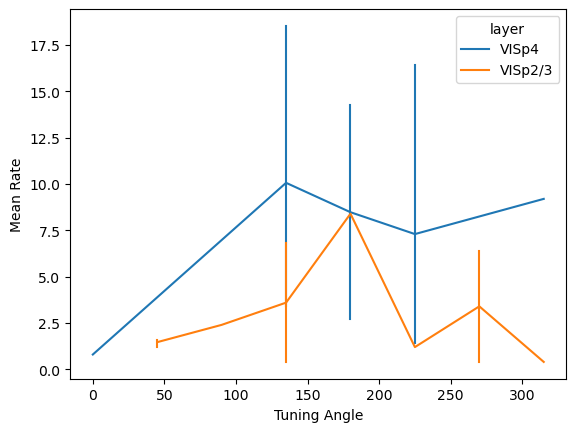

In [8]:
sns.lineplot(rates_df[rates_df['Cell Type']=='Exc'], x='Tuning Angle', y='Mean Rate', hue = 'layer', err_style='bars')